In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.9 MB/s eta 0:00:00a 0:00:01


In [3]:
import os
import nibabel as nib
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, ConvertToMultiChannelBasedOnBratsClassesd, Orientationd, Spacingd, Resized, RandFlipd, RandScaleIntensityd, RandShiftIntensityd, NormalizeIntensityd
from monai.data import ImageDataset
import os
import nibabel as nib
import numpy as np
from monai.data import DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, ConvertToMultiChannelBasedOnBratsClassesd, Orientationd, Spacingd, Resized, RandFlipd, RandScaleIntensityd, RandShiftIntensityd, NormalizeIntensityd
from monai.data import CacheDataset

In [4]:
import os
import sys
import time
import math
import copy
import torch
from torch import nn as nn
import numpy as np
from matplotlib import pyplot as plt
from easydict import EasyDict
from typing import List, Dict, Union, Sequence, Callable

from monai.data import DataLoader, CacheDataset, decollate_batch
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    Randomizable,
    Resized,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    ToTensord,
)
from monai.utils import set_determinism

2024-07-21 02:43:59.412078: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 02:43:59.412189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 02:43:59.543881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
root_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
output_dir = "/kaggle/working/"

In [6]:
def plot_data_distribution(num_train: int, num_val: int, num_test: int):
    """Plot number of data for train-set, val-set, and test-set after splitted"""

    # Create the bar chart
    bars = plt.bar(["Train", "Val", "Test"],
            [num_train, num_val, num_test], align='center', color=['green', 'red', 'blue'])

    # Add the data value on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()


def load_datalist(
    root_dir: str
) -> List[Dict]:
    """
    Load image/label paths of dataset
    """
    
    datalist = []
    for data in os.listdir(root_dir):
        data_dir_path = os.path.join(root_dir, data)
        if os.path.isdir(data_dir_path):
            model_scans = ["flair", "t1", "t1ce", "t2"]
            image_paths = [os.path.join(data_dir_path, f"{data}_{model}.nii") for model in model_scans]
            label_path = os.path.join(data_dir_path, f"{data}_seg.nii")

            if (all(os.path.exists(path) for path in [*image_paths, label_path])):
                datalist.append({
                    "image": image_paths,
                    "label": label_path
                })

    return datalist


class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):


    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 1 and label 4 to construct TC
            result.append(np.logical_or(d[key] == 1, d[key] == 4))
            # merge labels 1, 2 and 4 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 1, d[key] == 4), d[key] == 2
                )
            )
            # label 4 is ET
            result.append(d[key] == 4)
            d[key] = np.stack(result, axis=0).astype("float32")
        return d
    
    
class BratsDataset(Randomizable, CacheDataset):
    """
    Generate items for training, validation or test.
    """

    def __init__(
        self,
        root_dir: str,
        section: str,
        transform: Union[Sequence[Callable], Callable] = (),
        val_frac: float = 0.20,
        test_frac: float = 0.00,
        seed: int = 0,
        cache_num: int = sys.maxsize,
        cache_rate: float = 1.0,
        num_workers: int = 0,
    ) -> None:
        if not os.path.isdir(root_dir) or not os.path.exists(root_dir):
            raise RuntimeError(
                f"Cannot find dataset directory: {root_dir}."
            )

        self.section = section
        self.val_frac = val_frac
        self.test_frac = test_frac
        self.set_random_state(seed=seed)
        self.indices: np.ndarray = np.array([])
        
        data = self._generate_data_list(root_dir)
        CacheDataset.__init__(
            self, data, transform, cache_num=cache_num, cache_rate=cache_rate, num_workers=num_workers
        )

    def get_indices(self) -> np.ndarray:
        """
        Get the indices of datalist used in this dataset.
        """
        return self.indices

    def randomize(self, data: List[int]) -> None:
        self.R.shuffle(data)

    def _generate_data_list(self, root_dir: str) -> List[Dict]:
        datalist = load_datalist(root_dir)
        return self._split_datalist(datalist)

    def _split_datalist(self, datalist: List[Dict]) -> List[Dict]:
        length = len(datalist)
        indices = np.arange(length)
        self.randomize(indices)

        val_length = int(length * self.val_frac)
        test_length = int(length * self.test_frac)
        if self.section == "training":
            self.indices = indices[val_length+test_length:]
        elif self.section == "validation":
            self.indices = indices[test_length:val_length+test_length]
        else:
            self.indices = indices[:test_length]

        return [datalist[i] for i in self.indices]

In [7]:
import os
import nibabel as nib
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, 
    ConvertToMultiChannelBasedOnBratsClassesd, Orientationd, Spacingd, 
    Resized, RandFlipd, RandScaleIntensityd, RandShiftIntensityd, 
    NormalizeIntensityd, RandGaussianNoised, RandAdjustContrastd, RandRotate90d
)
from monai.data import ImageDataset

# Define the transformation pipeline
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        Resized(keys=["image", "label"], spatial_size=(128,128,128), mode="nearest"),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        RandRotate90d(keys=["image", "label"], prob=0.5 ),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        RandGaussianNoised(keys="image", mean=0.0, std=0.01, prob=0.5),  # Low noise
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)


In [8]:
def save_transformed_data(data_loader, output_dir):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    for batch_idx, batch in enumerate(data_loader):
        images = batch['image']
        labels = batch['label']
        
        # Example filenames (adjust as needed)
        image_filename = f"transformed_image_{batch_idx}.nii"
        label_filename = f"transformed_label_{batch_idx}.nii"
        
        # Save transformed images
        for i, image in enumerate(images):
            image_np = image.numpy().astype(np.float32)
            output_image_path = os.path.join(output_dir, image_filename.replace('.nii', f'_{i}.nii'))
            nib.save(nib.Nifti1Image(image_np, np.eye(4)), output_image_path)
        
        for i, label in enumerate(labels):
            label_np = label.numpy().astype(np.uint8)
            output_label_path = os.path.join(output_dir, label_filename.replace('.nii', f'_{i}.nii'))
            nib.save(nib.Nifti1Image(label_np, np.eye(4)), output_label_path)

# Define dataset and dataloader
train_ds = BratsDataset(
    root_dir=root_dir,
    section="training",
    transform=transform,
    cache_rate=0.0,
    num_workers=4
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = BratsDataset(
    root_dir=root_dir,
    section="validation",
    transform=transform,
    cache_rate=0.0,
    num_workers=4
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

# Define output directories
train_output_dir = '/kaggle/working/train'
val_output_dir = '/kaggle/working/val'

# Save transformed training and validation data
save_transformed_data(train_loader, train_output_dir)
save_transformed_data(val_loader, val_output_dir)


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


image shape: torch.Size([4, 128, 128, 128])
label shape: torch.Size([3, 128, 128, 128])


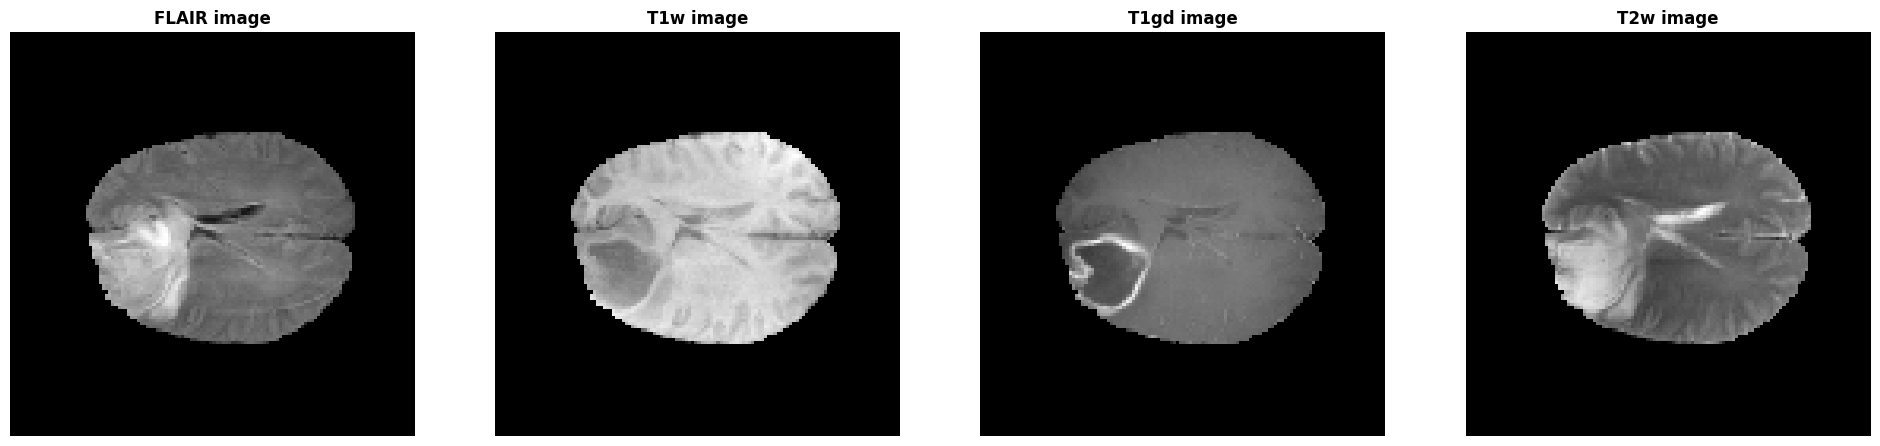

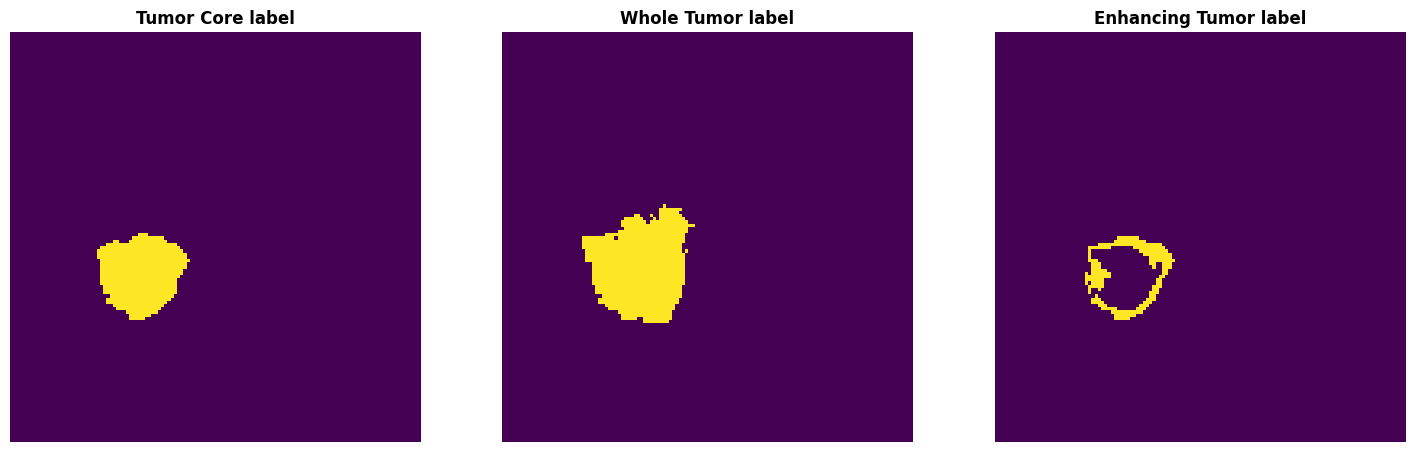

In [9]:
import matplotlib.pyplot as plt

# Define the slice number you want to visualize
slice_num = 55# You can change this number to the slice you are interested in

image_channels = ['FLAIR', 'T1w', 'T1gd', 'T2w']
label_channels = ['Tumor Core', 'Whole Tumor', 'Enhancing Tumor']

# Pick one image from BratsDataset to visualize and check the 4 channels
val_data_example = train_ds[10]
print(f"image shape: {val_data_example['image'].shape}")
print(f"label shape: {val_data_example['label'].shape}")

# Check if the slice number is within the valid range
if slice_num < 0 or slice_num >= val_data_example['image'].shape[-1]:
    raise ValueError(f"Slice number {slice_num} is out of range. Valid range is 0 to {val_data_example['image'].shape[-1] - 1}.")

# Visualize the image channels
plt.figure("image", (24, 6))
for i in range(len(image_channels)):
    plt.subplot(1, 4, i + 1)
    plt.title(f"{image_channels[i]} image", weight='bold')
    plt.imshow(val_data_example["image"][i, :, :, slice_num], cmap="gray")
    plt.axis('off')
plt.show()

# Visualize the label channels
plt.figure("label", (18, 6))
for i in range(len(label_channels)):
    plt.subplot(1, 3, i + 1)
    plt.title(f"{label_channels[i]} label", weight='bold')
    plt.imshow(val_data_example["label"][i, :, :, slice_num])
    plt.axis('off')
plt.show()


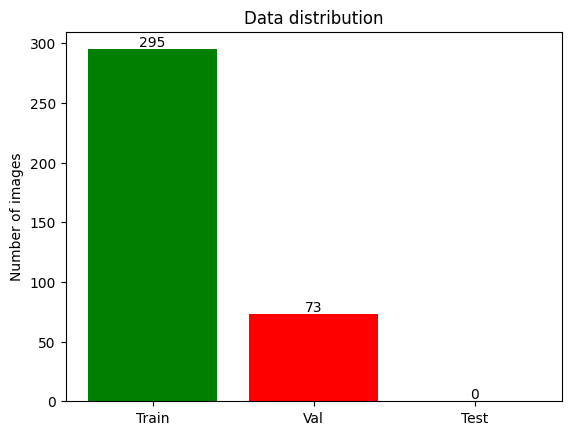

In [10]:
val_frac = val_ds.val_frac
test_frac = val_ds.test_frac

num_train = len(train_ds)
num_val = len(val_ds)
num_test = int(test_frac * num_val / val_frac)

plot_data_distribution(num_train, num_val, num_test)

In [13]:
import os
import shutil

# Define source directory and target directory
source_dir = '/kaggle/working/train'
mask_dir = os.path.join(source_dir, 'mask')

# Create 'mask' directory if it does not exist
if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

# Iterate through files in the source directory
for file_name in os.listdir(source_dir):
    file_path = os.path.join(source_dir, file_name)
    
    # Check if the file is a file (not a directory)
    if os.path.isfile(file_path):
        # Check if the file name contains 'label'
        if 'label' in file_name:
            # Move the file to the 'mask' directory
            shutil.move(file_path, os.path.join(mask_dir, file_name))
            print(f"Moved {file_name} to {mask_dir}")


Moved transformed_label_208_0.nii to /kaggle/working/train/mask
Moved transformed_label_145_0.nii to /kaggle/working/train/mask
Moved transformed_label_44_0.nii to /kaggle/working/train/mask
Moved transformed_label_176_0.nii to /kaggle/working/train/mask
Moved transformed_label_151_0.nii to /kaggle/working/train/mask
Moved transformed_label_115_0.nii to /kaggle/working/train/mask
Moved transformed_label_196_0.nii to /kaggle/working/train/mask
Moved transformed_label_58_0.nii to /kaggle/working/train/mask
Moved transformed_label_59_0.nii to /kaggle/working/train/mask
Moved transformed_label_162_0.nii to /kaggle/working/train/mask
Moved transformed_label_75_0.nii to /kaggle/working/train/mask
Moved transformed_label_122_0.nii to /kaggle/working/train/mask
Moved transformed_label_180_0.nii to /kaggle/working/train/mask
Moved transformed_label_159_0.nii to /kaggle/working/train/mask
Moved transformed_label_34_0.nii to /kaggle/working/train/mask
Moved transformed_label_81_0.nii to /kaggle/w